
# User Manual

## Content
1. How to get the NFEM teaching tool
2. Run a first example
3. Prediction
4. Nonlinear solution and path following
5. Critical points and branch switching
6. Postprocessing
7. Look into the code
8. Interactive GUI
9. FAQ

## 1. How to get the NFEM teaching tool
The NFEM teaching tool is hosted on gitlab.lrz.de. 

You can create an account using your TUM-id. If you follow the link below, you will see a list of the releases of the NFEM tool.
Please always download the latest version if nothing else is announced.

https://gitlab.lrz.de/chair_of_structural_analysis/NFEM_Teaching_Tool/tags

Download the .zip file and **unzip** it somewhere on your hard disk.

### 1.2 Get it using Git
If you are experienced with Git, you can also clone the repository.

### 1.3 Prerequisites

It is recommended to use the NFEM teaching tool with Anaconda for Python3: https://www.anaconda.com/download/
The following python modules are needed (all of them are included in the Anaconda installation):
- numpy
- matplotlib
- pyqt5

### 1.4 Keep it up to date

Note that the development for this tool started just recently. If you encounter problems, make sure you have the newest version.

## 2. Run a first example

The NFEM teaching tool is a python toolbox that can be imported in any python script. 
In the following, a simple example of a two-bar truss will be used to show the main functionalities. 
The main steps are:
- create an empty python file
- import the necessary modules
- preprocessing
- solution
- postprocessing

More details about these steps can be found in the subsequent sections.

### 2.1 Import the necessary python modules

In order to run the NFEM teaching tool from an arbitrary location, you first need to make the directory where you stored the NFEM teaching tool known to the system. It is the directory, where the ```nfem``` folder is located.

- You can use absolute paths by copying the path from windows explorer. Here you need to replace the ```\``` with ```/```, e.g.
```'C:\NFEM_tool'``` to ```'C:/NFEM_tool'```.
- Or relative paths, e.g. ```'../NFEM_tool'``` that navigates one folder up and then into the folder "NFEM_tool".


In [3]:
# add the path to the nfem tool to the PATH.
import sys
sys.path.append('..') 

Now you can import everything from the NFEM teaching tool

In [4]:
from nfem import *

Often also other modules like e.g. 'numpy' are necessary, if you want to use those you should also import them here

In [5]:
import numpy as np

### 2.2 Preprocessing

As a first step you create the finite element model, using node, elements, loads, and boundary conditions. The id of nodes, elements, and loads can be an integer or a string.

In [6]:
# create the model
model = Model('Two-Bar Truss')

# add the nodes
model.add_node(id='A', x=0, y=0, z=0)
model.add_node(id='B', x=1, y=1, z=0)
model.add_node(id='C', x=2, y=0, z=0)

# add the truss elements
model.add_truss_element(id=1, node_a='A', node_b='B', youngs_modulus=1, area=1)
model.add_truss_element(id=2, node_a='B', node_b='C', youngs_modulus=1, area=1)

# add a single load
model.add_single_load(id='load 1', node_id='B', fv=-1)

# add the supports
model.add_dirichlet_condition(node_id='A', dof_types='uvw', value=0)
model.add_dirichlet_condition(node_id='B', dof_types='w', value=0)
model.add_dirichlet_condition(node_id='C', dof_types='uvw', value=0)

Now you can already have a look at the model you created. 

(Please ignore the ```%matplotlib inline```, it is only necessary here to show the plot directly in the manual)

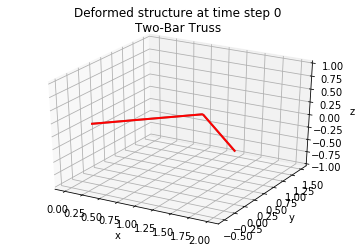

In [7]:
%matplotlib inline
#ignore the line above
show_deformation_plot(model)

### 2.3 Linear analysis

For a linear analysis, in general the following 3 steps are necessary to find a new equilibrium point:
1. Create a new model for the new solution step
2. Define the load factor
3. Perform a linear solution

In Detail: First create a new model for the first loading step. This is important because it creates a copy of the initial ```model```, that can be modified in the following analysis. This new ```linear_model``` knows that it was created from ```model```. Like this a chain of models is created for each solution step and it can be used later on to display load displacement curves, animations ...

In [8]:
# create a new model for the first solution step, using the initial model as a reference
linear_model = model.get_duplicate()

Set the load factor $\lambda$. Note that ```lambda``` is a python keyword, therefore we named the variable ```lam```

In [9]:
# define the load factor
linear_model.lam = 0.1

Perform a linear solution step

In [10]:
# perform a linear solution
linear_model.perform_linear_solution_step()


Start linear solution step...
lambda : 0.1


And now for a next solution step with a different load factor we repeat these steps. **Remember to duplicate the model!**

In [11]:
# create a new model for each new solution step, using the last model as a reference
linear_model = linear_model.get_duplicate() 
# define the load factor
linear_model.lam = 0.2
# perform a linear solution
linear_model.perform_linear_solution_step()


Start linear solution step...
lambda : 0.2


### 2.4 Non-linear analysis

For a non-linear analysis, on general the following 3 steps are necessary to find a new equilibrium point:
1. Create a new model for the new solution step
2. Predict a solution
3. Perform a nonlinear solution: corrects the prediction (finds equilibrium) using the Newton-Raphson algorithm

This is similar to the steps in the linear analysis, just that a little more input is needed from the user. 

In Detail:
First create a new model for the first non-linear solution step, using the initial model as a starting point.

In [12]:
# create a new model for the first solution step, using the initial model as a reference
non_linear_model = model.get_duplicate()

Now some user input is required. There are several predictor and path following methods available in the NFEM teaching tool.
Here we choose the most simple ones, you will hear more details in the following lectures and tutorials.

In [13]:
# define the load factor
lam = 0.1

# predict a solution by prescribing the load factor
non_linear_model.predict_tangential(strategy='lambda', value=lam)

There are several alternatives available for the prediction step. You can find them below.

In [14]:
# perform a non-linear solution step
non_linear_model.perform_non_linear_solution_step(strategy='load-control')


Start non linear solution step...
  Newthon-Raphson converged in step 4.
  Residual norm: 6.250451947686919e-09.
Solution found after 4 iteration steps.
Det(K): 0.19510608810631772


And now for a next solution step with a different load factor we repeat these steps. **Remember to duplicate the model!**

In [15]:
# create a new model for each solution step, using the last model as a reference
non_linear_model = non_linear_model.get_duplicate()

# define the load factor
lam = 0.2

# predict a solution by prescribing the load factor
non_linear_model.predict_tangential(strategy='lambda', value=lam)

# perform a non-linear solution step
non_linear_model.perform_non_linear_solution_step(strategy='load-control')


Start non linear solution step...
  Newthon-Raphson converged in step 12.
  Residual norm: 3.443661026059086e-07.
Solution found after 12 iteration steps.
Det(K): 1.0488382394392952


### 2.5 Postprocessing

After you have done your calculations, you can postprocess your results.

#### Load displacement diagram

In order to compare the load displacement curves of the the linear and nonlinear analysis, you can create a 2D plot and add the load-displacement-curves of the two models. Note that you need to specify the dof you want to plot against the load factor $\lambda$. (Please ignore the ```%matplotlib inline```, it is only necessary here to show the plot directly in the manual)

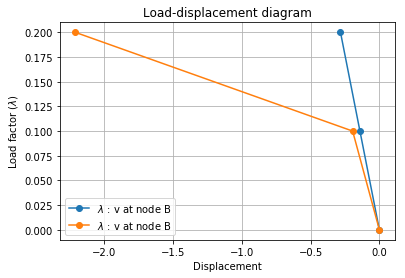

In [16]:
%matplotlib inline
#ignore the line above

# create a 2D plot 
plot = Plot2D()

# add the load-displacement curves you want to plot
plot.add_load_displacement_curve(linear_model, dof=('B', 'v'))
plot.add_load_displacement_curve(non_linear_model, dof=('B', 'v'))

# show the plot
plot.show()

#### Deformation plot

You can also visualize the deformation of the structure. As an example the linear_model is plotted.

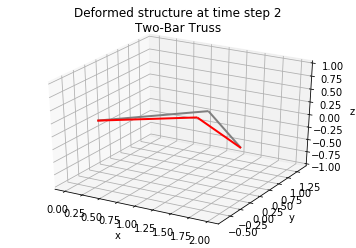

In [17]:
%matplotlib inline
#ignore the line above

# static plot
deformation_plot = DeformationPlot3D()
deformation_plot.show(linear_model)

#### Deformation animation

You can also animate the deformation history of each model, with the following command (here the first frame of the animation is shown):

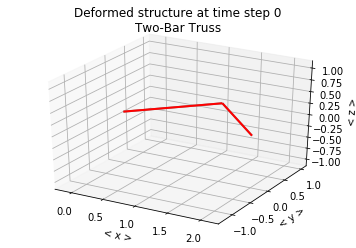

In [18]:
%matplotlib inline
#ignore the line above

# animated plot
animation = Animation3D()
animation.show(non_linear_model)

# 3. Prediciton

A new equilibrium point in a non linear analysis is found by the following two steps:
- prediction
- solution (see section 4)

In the predictor step a solution is predicted, in principle you can do this by modifying the model directly, like we did e.g. in the linear example above. This will work for simple models, but is not recommended in general.

In [19]:
predicted_model = non_linear_model.get_duplicate()

# define the load factor as prediction
predicted_model.lam = 0.1

# or prescribe a the state of dof 'v' at node 'B' as prediction
predicted_model.set_dof_state(('B','v'), -0.1)

## Tangential prediction

By using the tangent vector at the current equilibrium point, a better prediction for the next equilibrium point on the load curve can be made. The tangent vector is scaled according to the chosen strategy and the given value . For an example see the code below using the ```strategy='delta-dof'```. There the tangential vector is scaled sucht, that the increment of the dof 'v' at node 'B' is 0.1. If you want to prescribe the dof directly instead of the increment, use the strategy ```strategy='dof'``` instead. The following strategies are available. Note the additional ```dof``` parameter for the dof related strategies.
- ```strategy='lambda'```
- ```strategy='delta-lambda'```
- ```strategy='dof', dof=('B','v')```
- ```strategy='delta-dof', dof=('B','v')```
- ```strategy='arc-length'```

In [20]:
predicted_model = model.get_duplicate()

# predict with the tangent vector such that the increment of the dof 'v' at node 'B' is 0.1
predicted_model.predict_tangential(strategy='delta-dof', dof=('B','v'), value=-0.1)

# 4. Nonlinear solution and path following

The function ```perform_non_linear_solution_step``` of the model does the correctorsteps starting from the predicted solution so that the equilibrium is achieved and the final solution after this step is on the equilibrium path.

For the solution a constraint or so called path following method is necessary. There are three methods implemented.
- ```strategy='load-control'```: Keeps the prescribed load factor constant while solving
- ```strategy='displacement-control', dof=('B','v')```: Keeps the prescribed dof constant while solving 
- ```strategy='arc-length-control'```: Keeps the prescribed arc-length constant while solving

## Additional options

There are some additional function parameters:
- ```tolerance=1e-5```
- ```max_iterations=100```
- ```solve_det_k=True```
- ```solve_attendant_eigenvalue=False```

For more detailed description, look at the documentation of the function in the ```model.py``` file

In [21]:
# displacement control (the controlled dof needs to be specified) with additional options
predicted_model.perform_non_linear_solution_step(strategy='displacement-control', dof=('B','v'), 
                                                 tolerance=1e-5, 
                                                 max_iterations=100, 
                                                 solve_attendant_eigenvalue=True)


Start non linear solution step...
  Newthon-Raphson converged in step 2.
  Residual norm: 0.0.
Solution found after 2 iteration steps.
Det(K): 0.32353749999999987
Attendant eigenvalue analysis ...
Closest eigenvalue: 8.526315789473678
Closest eigenvalue * lambda: 0.515480843484993
Closest eigenvector: [0. 1.]


# 5. Critical points and branch switching

A critical point can be identified by a ```Det(K)=0```. For large models this can lead to numerical problems, but for small models and teaching purposes this is a sufficient criterion.

Finding a critical point can be done manually, by incrementing the load factor and checking the determinant of the stiffness matrix of the model ```model.det_k```. This is kind of tedious but can easily be automated:

## Bracketing

The bracketing function finds the next equilibrium point of a model by iteratively by predicting with the ```arc-length``` strategy and nonlinear solution with ```arc-lenght-control```. The length of the predictor is adapted such that the equilibrium point has a absolute value of the determinant smaller then a given tolerance. This works the same way for limit and bifurcation points.

In [22]:
%%capture 
#Ignore the line above, it just supresses the output of the ~22 iterations in the following bracketing function.

# find the next critical point starting from the last equilibrium point of the 'non_linear_model'
critical_model = bracketing(predicted_model)


## Branch switching

At a bifurcation point, more than one tangent vector exists. As we are still on the primary path after finding the critical point, we will also calculate the tangent vector of this primal path. If we predict using this tangent, we will most probably find the primal path with the Newton-Raphson algorithm.

In order to switch to the secondary branch, we need to modify this tangent prediction.
The first eigenvector of the system at the critical point indicates the buckling mode, hence it is a good predictor if we want to switch to the secondary path. 

The ```combine_prediction_with_eigenvector``` function modifies the prediction by linearly combining it with the eigenvector.
```new_predictor = predictor (1.0-|beta|) + eigenvector*beta```, with the function parameter ```beta``` between ```-1.0``` and ```1.0```.

In [23]:
# create a new model for each solution step, using the last model as a reference
bifurcated_model = critical_model.get_duplicate()

# predict using the tangent of the primal path
bifurcated_model.predict_tangential(strategy='arc-length')

# modify this prediciton by combination with the eigenvector at the critical point
bifurcated_model.combine_prediction_with_eigenvector(beta=1.0)

# solve with the modified predictor
bifurcated_model.perform_non_linear_solution_step(strategy='arc-length-control')


Start non linear solution step...
  Newthon-Raphson converged in step 1.
  Residual norm: 6.082375333227308e-06.
Solution found after 1 iteration steps.
Det(K): 1.239905545430863e-07


With this modified predictor, you can perform a nonlinear solutionstep and then proceed to follow the secondary path to evaluate the post-buckling behaviour.

## Linearized Pre-Buckling LPB

In order to do a linearized prebuckling analysis, you need to first perform a **linear** solution and then call a linearized eigenvalue solution. Note that we already solved the linear model above.
For such models with nonlinear behaviour, the lienarized pre-buckling analysis will overestimate the critical load factor, therefor be unsafe!

In [24]:
# after the linear solution, perform the eigenvalue analysis
linear_model.solve_linear_eigenvalues()

Linearized prebuckling (LPB) analysis ...
First linear eigenvalue: 3.535533905932734
First linear eigenvalue * lambda: 0.7071067811865469
First linear eigenvector: [1. 0.]


# 6. Postprocessing

There are several functions available for the post processing of the model and the load displacement curves.

## 2DPlot - graphs

The ```Plot2D``` object can be used to plot curves to describe e.g. the load displacement history or other quantities to describe the structural behaviour. 

### Default curves

There are some predefined functions available:

### Generic history curve

To be most flexible, you can plot any history information of the model using the function ```add_history_curve```.
In order to do so, you need to define how the values for ```x``` and ```y``` can be obtained from the model.
An example for this generic function to plot the eigenvalues of the model is shown below. Like this you can also easily manipulate the data, note the multiplication of the eigenvalue with the load-factor. With the ```label``` parameter you can give a name to the curve.

### Generic curve

You can also add any other curve using matplotlib syntax with the function ```add_custom_curve```.
The syntax here is the same as for matplotlib: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html .

### Show plot

After adding all the curves, you display the plot usint the ```show``` function.

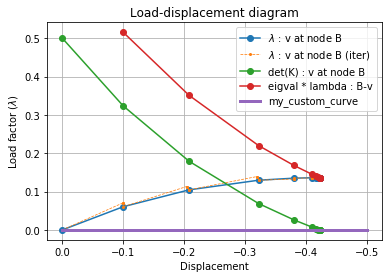

In [25]:
# create the plot object
plot = Plot2D()

# inverts the x axis, negative x points to the left
plot.invert_xaxis()


# === default history curve

# default load displacement curve, with a flag if the iterations should also be plotted
plot.add_load_displacement_curve(bifurcated_model, dof=('B', 'v'), show_iterations=True)

# default function to plot Det(K) against a dof
plot.add_det_k_curve(bifurcated_model, dof=('B', 'v'))


# === generic history curve

# plot the first eigenvalue*lambda using the general historic plot function
def eigenvalue_data_function(model):
    """This function is called for each model in the history. It returns the
    values for x and y of a model.
    """
    x = model.get_dof_state(dof=('B', 'v'))
    if model.first_eigenvalue is None:
        y = None
    else:
        y = model.first_eigenvalue * model.lam
    return x, y
plot.add_history_curve(bifurcated_model,
                        x_y_data=eigenvalue_data_function,
                        label='eigval * lambda : B-v')


# === generic curve

# plot a function to highlight the x axis at y=0.0
x=[0,-0.5] 
y=[0, 0]
plot.add_custom_curve(x, y, label="my_custom_curve", linewidth=3.0)


# === show 

plot.show()

## 3D plot and 3D animation

See section 2.5.

# 7. Look into the code

You are higly encuraged to look into the python NFEM python code. We tried to keep it as readable as possible and clean.
Everything related to the FEM is located in the 'nfem' directory. 
All the main functionalities and classes are documented as shown below:

```python
"""documentation of the module (file)"""

class CustomClass():
    """documentation of the class"""
    
    def function(self):
        """documentation of the function"""
```

If you are not sure about how to call a certain function, try reading the documentation of the code.
If you have any questions, don't hesitate to contact us.


The subfolder ```tests``` contains some tests for the nfem code, the subfolder ```visualization``` contains all the plot and gui functionalities.

# 8. Interactive GUI

The NFEM teaching tool can not only be used with custom user scripts, but also with an interactive GUI.
It offers the most important functionalities that where described in the previous sections. You can interact with a model by simply calling the ```interact``` function. You need to define on which model you want to interact and what dof should be traced. 
The model history that you may already solved in the script befor you call the interact function is preserved.
Note that you can change the traced dof interactively in the GUI.

After your interaction with the model you can continue to work on the model using the python functions.

In [26]:
model_after_interaction = interact(model=critical_model, dof=('B','v'))

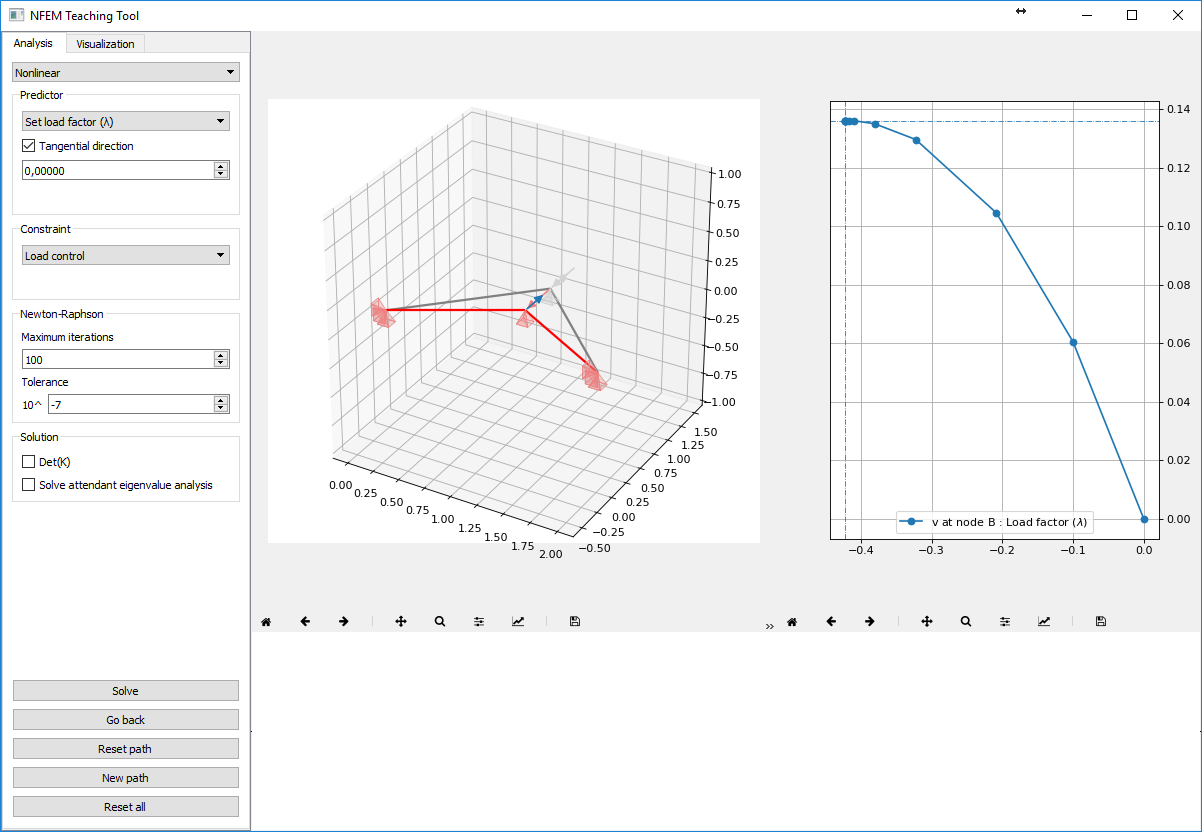

# 9. FAQ

### ModuleNotFoundError: No module named 'nfem'

Your python does not find the nfem module. Make sure you set the right path in your python script. See section 2.1.

### Plots are not poping up, but shown in the console

You are probably running the NFEM teaching tool with IPython, this is the case if you are using 'Spyder'. The NFEM teaching tool, trys to set up the spyder environment such that everything works, but this can possibly fail. If that is the case, try to do the follwing:

If you are running the NFEM teaching tool with 'Spyder' you need to change a setting so that animations can be shown.
Type ```%matplotlib tk``` in the console before running the script. This needs to be done every time you reopen Spyder.

To change it permanently, go to ```Tools-Preferences-Ipython console-Graphics-Backend``` and select ```Tkinter```. You need to restart spyder or the console after you made this change.

### I cannot find my question in the FAQ

Don't hesitate to contact us, we are thankful for every comment on the tool.